In [1]:
import random

import torch
from torch import nn
from torchvision import datasets
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader
from torch.optim import Adam, SGD
import numpy as np
import matplotlib as mpl
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from torcheval.metrics import FrechetInceptionDistance


from modelsv2 import NetD, NetG

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'
display(f'Device {device} is available.')

manual_seed = 999
torch.manual_seed(manual_seed)
random.seed(manual_seed)
#torch.use_deterministic_algorithms(True)

'Device cuda is available.'

In [3]:
dc_gen = NetG().to(device)
dc_dis = NetD().to(device)

batch_size = 128
#lr = 0.0002
lr = 0.0002
epochs = 50
loss_fn = nn.BCELoss()
fixed_noise = torch.randn((64, 100, 1,1), device=device)
fixed_labels = torch.randint(0,10, (64,1)).to(device)
# Other normalization factors are located here:  https://github.com/kuangliu/pytorch-cifar/issues/19
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader = DataLoader(datasets.CIFAR10(root='./hw4data', train=True, transform=transform, download=True), batch_size=batch_size,shuffle=True)
test_loader =  DataLoader(datasets.CIFAR10(root='./hw4data', train=False, transform=transform, download=True), batch_size=batch_size,shuffle=True)

gen_optimizer = Adam(dc_gen.parameters(), lr=lr, betas=(.5, .999))
dis_optimizer = Adam(dc_dis.parameters(), lr=lr, betas=(.5, .999))
#dis_optimizer = SGD(dc_dis.parameters(), lr=lr) 

Files already downloaded and verified
Files already downloaded and verified


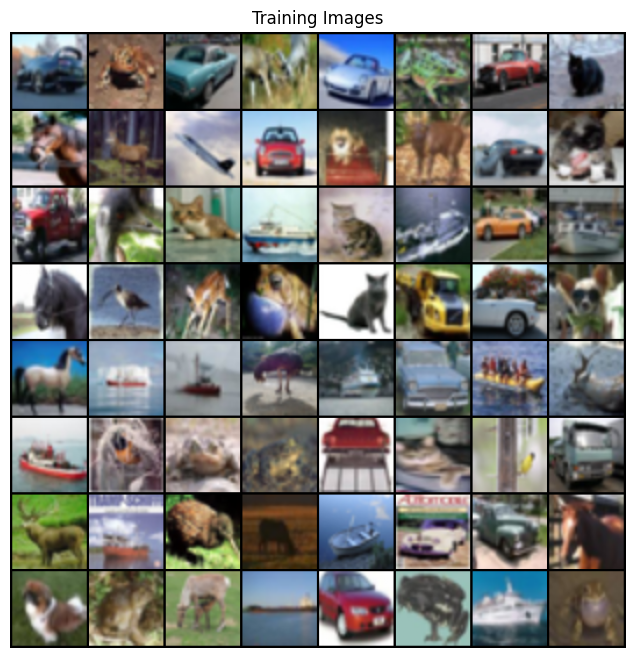

In [4]:
data = next(iter(train_loader))
data[0].shape

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(data[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [5]:

def init_weights(m):
    """Adapted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html. """
    clazz = m.__class__.__name__
    if clazz.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif clazz.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

dc_gen.apply(init_weights)
dc_dis.apply(init_weights)

display(dc_gen)
display(dc_dis)



NetG(
  (embedding): Embedding(10, 100)
  (sequence): Sequential(
    (0): ConvTranspose2d(200, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bi

NetD(
  (embedding): Embedding(10, 512)
  (sequence): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (last_conv2d): Conv2d(1024, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (flatten): Fl

In [6]:
def train(g, d, gen_optimizer, dis_optimizer, loss_fn, train_loader, epoch):
    derrors, gerrors, gen_imgs, dx, d_g_x1, d_g_x2= [],[], [], [],[], []
    fid = FrechetInceptionDistance(device = device)    
    for idx, data in enumerate(train_loader):    
        g.train()
        d.train()
        
        fid.update((data[0]-data[0].min())/(data[0].max()-data[0].min()), is_real=True)
        d.zero_grad()
        imgs = data[0].to(device)
        batch_size = imgs.size(0)
        label = torch.full((batch_size,), .9, dtype=torch.float, device=device)
        # Real images with discriminator
        output = d(imgs, data[1].to(device))
        d_real_error = loss_fn(output.squeeze(), label)
        d_real_error.backward()      
        dx.append(output.mean().item())

        # Fake images with discriminator
        zvector = torch.randn((batch_size, 100, 1, 1), device=device)
        fakes = g(zvector, data[1].to(device))
        output = d(fakes.detach(), data[1].to(device))
        bad_label = torch.full((batch_size,), 0, dtype=torch.float, device=device)
        d_fake_error = loss_fn(output.squeeze(),bad_label)
        d_fake_error.backward()
        d_g_x1.append(output.mean().item())
        
        #(d_real_error + d_fake_error).backward()

        dis_optimizer.step()
        total_Derror = d_fake_error + d_real_error
        #total_Derror.backward()
        derrors.append(total_Derror.item())
        

        # Do the loss of G
        g.zero_grad()
        trick_label = torch.full((batch_size,), .9, dtype=torch.float, device=device)
        #fakes = g(zvector)
        output = d(fakes, data[1].to(device))
        g_error = loss_fn(output.squeeze(), trick_label)
        gerrors.append(g_error.item())
        #print(g_error)
        g_error.backward()
        gen_optimizer.step()
        d_g_x2.append(output.mean().item())

        if idx == (len(train_loader) -1) and (epoch+1) % 5 == 0:
            with torch.no_grad():
                g.eval()
                #torch.randint(0,10, (64,1)).to(device).detach().cpu()
                extra_fake = g(fixed_noise, fixed_labels) #data[1].to(device)).detach().cpu()
                gen_imgs.append(vutils.make_grid(extra_fake, padding=2, normalize=True))
                
                fig = plt.figure(figsize=(8,8))
                plt.axis("off")
                plt.imshow(np.transpose(vutils.make_grid(fakes, padding=2, normalize=True).cpu(), (2,1,0)))
                plt.show()
                plt.close(fig)
                
        if idx == (len(train_loader) -1):
            fid.update((fakes-fakes.min())/(fakes.max()-fakes.min()), is_real=False)


    return derrors, gerrors, gen_imgs, dx, d_g_x1, d_g_x2, fid.compute().item()

epoch: 0, D_Loss: 1.2676117814257932, G_Loss: 6.175641964463627, Dx: 0.6874400083442478, D_G_x1: 0.2238729879545531, D_G_x2: 0.02868018870542827, FID:364.2646789550781
epoch: 1, D_Loss: 0.90623306008556, G_Loss: 4.216731547089794, Dx: 0.7217658880307242, D_G_x1: 0.174106905596721, D_G_x2: 0.031083170388429813, FID:310.1242980957031
epoch: 2, D_Loss: 0.8752966218287378, G_Loss: 3.676125521550093, Dx: 0.7105350961808659, D_G_x1: 0.18873758874654198, D_G_x2: 0.038687931348500765, FID:281.3742370605469
epoch: 3, D_Loss: 0.8755007326755377, G_Loss: 3.6801623157832934, Dx: 0.7075261991194752, D_G_x1: 0.19146452901784874, D_G_x2: 0.03768384105378829, FID:200.24319458007812


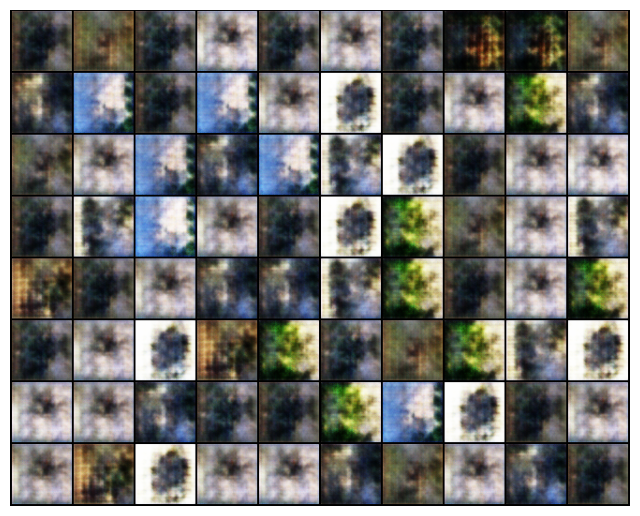

epoch: 4, D_Loss: 0.8230332982966967, G_Loss: 3.5741992115669543, Dx: 0.719425312622124, D_G_x1: 0.1796487557363537, D_G_x2: 0.03876243427391652, FID:196.2930908203125
epoch: 5, D_Loss: 0.8469635508097041, G_Loss: 3.481249376331144, Dx: 0.7075885666148437, D_G_x1: 0.1913972310638508, D_G_x2: 0.04242379506043566, FID:197.51925659179688
epoch: 6, D_Loss: 0.8841539581718347, G_Loss: 3.266330192461038, Dx: 0.6964767419011392, D_G_x1: 0.20241395273314947, D_G_x2: 0.056401483439024576, FID:156.48098754882812
epoch: 7, D_Loss: 0.915167640999455, G_Loss: 3.106159699542443, Dx: 0.684127598238723, D_G_x1: 0.21405587444448715, D_G_x2: 0.06749367546034105, FID:161.8592529296875
epoch: 8, D_Loss: 0.9121991203873968, G_Loss: 3.064930900893248, Dx: 0.6857244097973074, D_G_x1: 0.21505952823926192, D_G_x2: 0.06812107569390378, FID:148.32037353515625


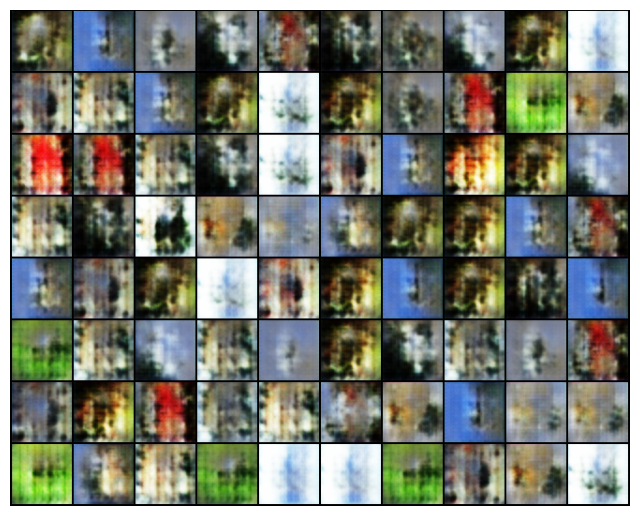

epoch: 9, D_Loss: 0.9560264207213126, G_Loss: 2.9913203656825873, Dx: 0.6713407497729182, D_G_x1: 0.22852040132712526, D_G_x2: 0.07728908478539637, FID:130.79933166503906
epoch: 10, D_Loss: 0.9931251961556847, G_Loss: 2.863650878676978, Dx: 0.6583011672853509, D_G_x1: 0.240945082117358, D_G_x2: 0.08445678324774479, FID:120.75447845458984
epoch: 11, D_Loss: 0.9749129414558411, G_Loss: 2.821079718487342, Dx: 0.6617166662536313, D_G_x1: 0.2372760082835622, D_G_x2: 0.08723985854892985, FID:123.6414566040039
epoch: 12, D_Loss: 0.9779631530537325, G_Loss: 2.7234923681029883, Dx: 0.6590419161655104, D_G_x1: 0.24096755671512593, D_G_x2: 0.09200323834214978, FID:116.08597564697266
epoch: 13, D_Loss: 0.9851683887374371, G_Loss: 2.643741315130687, Dx: 0.655501862773505, D_G_x1: 0.2459222825668047, D_G_x2: 0.10096263155922332, FID:116.74189758300781


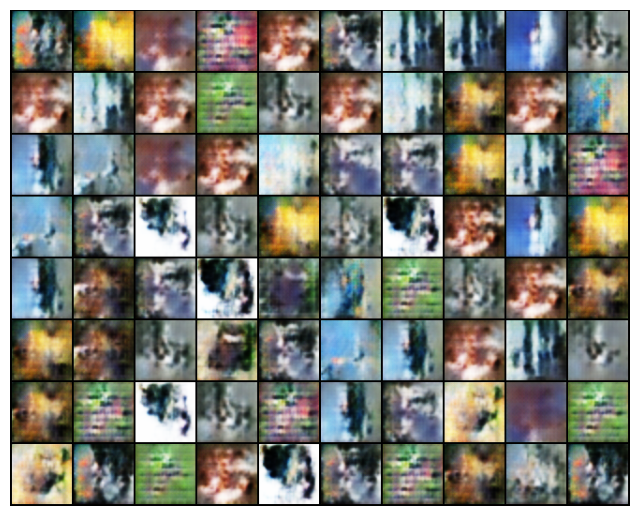

epoch: 14, D_Loss: 1.005799321567311, G_Loss: 2.576619704361157, Dx: 0.6514687392946399, D_G_x1: 0.2473887089125412, D_G_x2: 0.10964834950376026, FID:118.84550476074219
epoch: 15, D_Loss: 1.0110864512755742, G_Loss: 2.5234542455514677, Dx: 0.6489422425075108, D_G_x1: 0.2513726940021262, D_G_x2: 0.11383241946782793, FID:102.020263671875
epoch: 16, D_Loss: 1.015152446906585, G_Loss: 2.4808154860725793, Dx: 0.6472036060317398, D_G_x1: 0.25225272586526315, D_G_x2: 0.1178527526549109, FID:103.99095916748047
epoch: 17, D_Loss: 0.9788076534600514, G_Loss: 2.524704156629265, Dx: 0.6564444636597353, D_G_x1: 0.24326731088807058, D_G_x2: 0.1129202549947221, FID:115.06669616699219
epoch: 18, D_Loss: 1.0014229035743363, G_Loss: 2.611793975543488, Dx: 0.6557836318031296, D_G_x1: 0.24469008657585858, D_G_x2: 0.10756331115134556, FID:104.66552734375


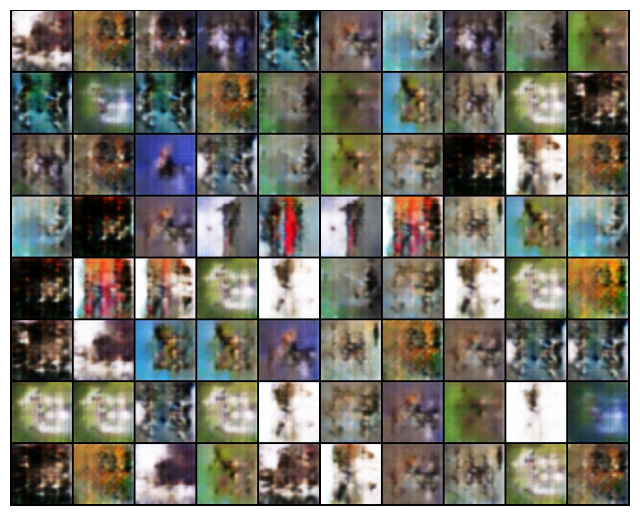

epoch: 19, D_Loss: 0.9806566867986908, G_Loss: 2.5902291075195496, Dx: 0.6616537055796217, D_G_x1: 0.23771148351618968, D_G_x2: 0.11249632948218748, FID:115.15131378173828
epoch: 20, D_Loss: 0.9607335800100165, G_Loss: 2.5977808795011867, Dx: 0.6647920499905906, D_G_x1: 0.23540254746375563, D_G_x2: 0.10514303861910006, FID:103.85505676269531
epoch: 21, D_Loss: 0.9373596507265135, G_Loss: 2.8176654273896573, Dx: 0.6773946774204064, D_G_x1: 0.22199777345461272, D_G_x2: 0.0915279536855781, FID:98.43428039550781
epoch: 22, D_Loss: 0.904136449784574, G_Loss: 2.7757643946753743, Dx: 0.6902249333308176, D_G_x1: 0.21006905170552947, D_G_x2: 0.09186126004762786, FID:112.97042846679688
epoch: 23, D_Loss: 0.893212251879675, G_Loss: 2.9444791572478115, Dx: 0.6968300657732712, D_G_x1: 0.20236761820838428, D_G_x2: 0.08372984894657332, FID:108.96866607666016


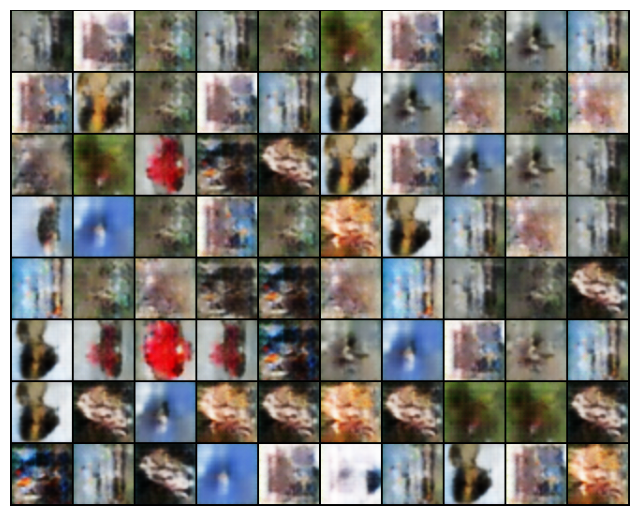

epoch: 24, D_Loss: 0.8854244458858315, G_Loss: 2.998307312083671, Dx: 0.7049499362554696, D_G_x1: 0.19502315311776022, D_G_x2: 0.07973237564493105, FID:113.17463684082031
epoch: 25, D_Loss: 0.8286585231571246, G_Loss: 3.0591386532234717, Dx: 0.7204312694632946, D_G_x1: 0.17986789679743082, D_G_x2: 0.07303865321347956, FID:106.44501495361328
epoch: 26, D_Loss: 0.8356247765328878, G_Loss: 3.094193252608599, Dx: 0.723118473654208, D_G_x1: 0.17712496326196595, D_G_x2: 0.07453488688046575, FID:112.70875549316406
epoch: 27, D_Loss: 0.8165637150292506, G_Loss: 3.177900439790448, Dx: 0.7281806670472293, D_G_x1: 0.17216374874895063, D_G_x2: 0.06882249635590366, FID:107.0693588256836
epoch: 28, D_Loss: 0.8090193992685479, G_Loss: 3.2029856492186446, Dx: 0.7306390429425347, D_G_x1: 0.1687050438408628, D_G_x2: 0.06621017283037998, FID:112.07624816894531


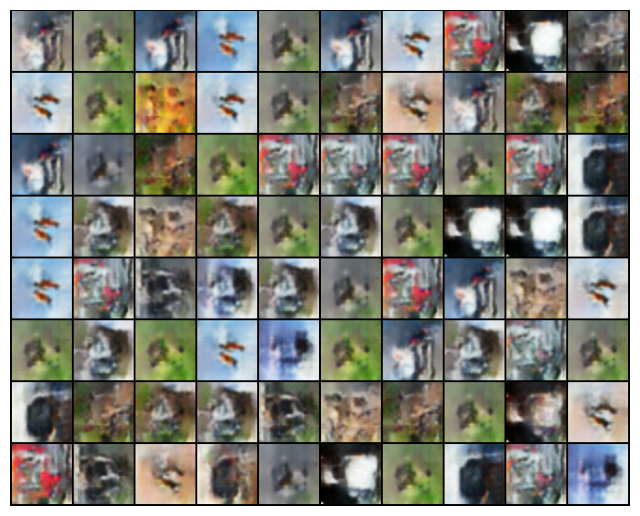

epoch: 29, D_Loss: 0.719254380677972, G_Loss: 3.3806302236474077, Dx: 0.7646351025423126, D_G_x1: 0.1347065092072777, D_G_x2: 0.05343257435670425, FID:113.48693084716797
epoch: 30, D_Loss: 0.7496803272563173, G_Loss: 3.368821465527005, Dx: 0.7573476105194796, D_G_x1: 0.1431272808081873, D_G_x2: 0.05560009198243488, FID:109.10469055175781
epoch: 31, D_Loss: 0.7471609223834084, G_Loss: 3.4543842257136275, Dx: 0.7588338172611069, D_G_x1: 0.13966568849642602, D_G_x2: 0.054744549018963265, FID:118.19110107421875
epoch: 32, D_Loss: 0.7552492140656542, G_Loss: 3.440549743907226, Dx: 0.7594183032088877, D_G_x1: 0.14053691489606515, D_G_x2: 0.05522857450493349, FID:122.90242004394531
epoch: 33, D_Loss: 0.7256167041676124, G_Loss: 3.4506387433127674, Dx: 0.768900995921639, D_G_x1: 0.1301429463559976, D_G_x2: 0.05091477558009334, FID:102.76158905029297


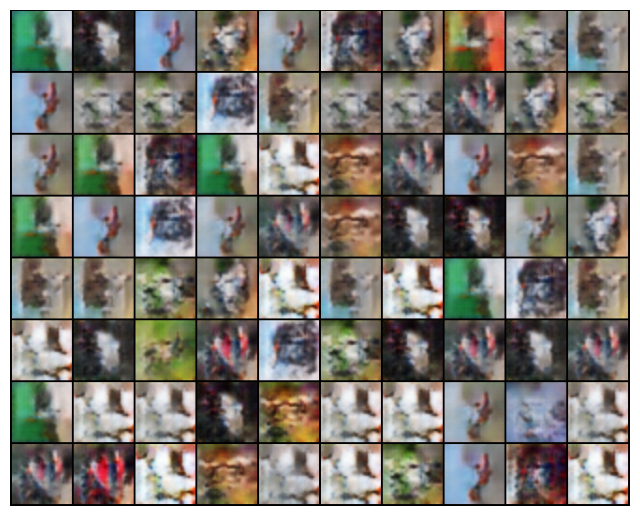

epoch: 34, D_Loss: 0.7125955140956527, G_Loss: 3.485688457479867, Dx: 0.7723853499497599, D_G_x1: 0.12903586084849636, D_G_x2: 0.05149301963627858, FID:119.14322662353516
epoch: 35, D_Loss: 0.7261442930802054, G_Loss: 3.4792634872981654, Dx: 0.7687171653408529, D_G_x1: 0.13112899002238282, D_G_x2: 0.05422804502407363, FID:108.2015380859375
epoch: 36, D_Loss: 0.7399390903122894, G_Loss: 3.6379442620460334, Dx: 0.7712529517109971, D_G_x1: 0.12718381692029465, D_G_x2: 0.04694275268070727, FID:109.49860382080078


KeyboardInterrupt: 

In [7]:
# Training Loop
alld, allg, all_imgs, fids = [],[],[], []
for epoch in range(epochs):
    d_real_error, g_error, gen_imgs, dx, d_g_x1, d_g_x2, fid = train(dc_gen, dc_dis, gen_optimizer, dis_optimizer, loss_fn, train_loader, epoch)
    print(f'epoch: {epoch}, D_Loss: {sum(d_real_error)/len(d_real_error)}, G_Loss: {sum(g_error)/len(g_error)}, Dx: {sum(dx)/len(dx)}, D_G_x1: {sum(d_g_x1)/len(d_g_x1)}, D_G_x2: {sum(d_g_x2)/len(d_g_x2)}, FID:{fid}')
    alld.extend(d_real_error)
    allg.extend(g_error)
    all_imgs.extend(gen_imgs)
    fids.append(fid)


In [ ]:
mpl.rcParams['animation.embed_limit'] = 2**128
fig = plt.figure(figsize=(8,8))
plt.axis("off")
image = [[plt.imshow(np.transpose(i.cpu()[:3], (1,2,0)), animated=True)] for i in all_imgs]
#image = [[plt.imshow(i.cpu(), animated=True)] for i in all_imgs]
ani = animation.ArtistAnimation(fig, image, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
len(allg)

In [ ]:
# alliters = list(range(alld))

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(allg,label="G")
plt.plot(alld,label="D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
torch.save(dc_gen.state_dict(),'generate2.pth')
torch.save(dc_dis.state_dict(), 'discriminator2.pth')

# dc_gen, dc_dis

In [ ]:
dc_gen.eval()
rando_noise = torch.randn(1,100,1,1)
img = dc_gen(rando_noise.to(device), data[1][0].to(device))
fig = plt.figure(figsize=(1,1))
plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True).cpu(), (2,1,0)))
#img.cpu().detach()
#np.transpose(img.detach().cpu(), (1,2,0))
#fixed_noise[0,:].unsqueeze(0).shape
torch.full((1,100,1,1), .75 ).shape

In [ ]:
gen_imgs[0].shape

In [ ]:
# alliters = list(range(alld))

plt.figure(figsize=(10,5))
plt.title("FID During Training")
plt.plot(fids)
plt.xlabel("Iterations")
plt.ylabel("FID Score")
plt.legend()
plt.show()